In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import math

In [2]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [3]:
#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])

In [4]:
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None

In [5]:
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)

In [6]:
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7995,7995,0.333491,0.682035,0.220176,0.249060,0,NaN
7996,7996,0.344994,0.689298,0.225088,0.218040,1,NaN
7997,7997,0.390017,0.641338,0.211275,0.239294,1,NaN
7998,7998,0.324577,0.656867,0.205467,0.294698,1,NaN


In [7]:
#get starting points 
startingPoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        timePoint = row['Timestep'] + 1
        startingPoints.append(timePoint)

In [8]:
def getTimeFromStart(current, startList):
    currentEpisodeStartIndex = -1 #initialise negative value first
    for s in range(len(startList)):
        start = startList[s]
        if start - current > 0: 
            break 
        currentEpisodeStartIndex = s
    if currentEpisodeStartIndex >= 0:
        startPointTime = startList[currentEpisodeStartIndex]
        diff = current - startPointTime
        return int(diff)
    else: 
        return current

In [9]:
#get data on time elapsed from start of episode 
total_time_from_start = []
for timePoint in timeX:
    current_time_from_start = getTimeFromStart(timePoint, startingPoints)
    total_time_from_start.append(current_time_from_start)

In [10]:
all_df['Time_elapsed'] = total_time_from_start
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL,Time_elapsed
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0,0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0,1
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0,2
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0,3
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0,4
...,...,...,...,...,...,...,...,...
7995,7995,0.333491,0.682035,0.220176,0.249060,0,NaN,3
7996,7996,0.344994,0.689298,0.225088,0.218040,1,NaN,4
7997,7997,0.390017,0.641338,0.211275,0.239294,1,NaN,5
7998,7998,0.324577,0.656867,0.205467,0.294698,1,NaN,6


In [11]:
#add anomaly data

#load anomaly detection model
anomalyDetector = tf.keras.models.load_model('AE_tuneActivation_code_relu.h5')

anomalyData = []

for index, row in all_df.iterrows():
    sensorReadings = np.array([row['Volt'], row['Rotate'], row['Pressure'], row['Vibration']])
    sensorReadings = np.reshape(sensorReadings, (1,4))
    predictions = anomalyDetector.predict(sensorReadings)
    anomalyScore = (np.mean(np.power(sensorReadings - predictions, 2), axis=1))**0.5
    
    if anomalyScore < 0.0838:
        isAnomaly = 0
    else:
        isAnomaly = 1
        
    anomalyData.append(isAnomaly)
    
all_df['Anomalous'] = anomalyData

In [12]:
#drop na columns 
all_df = all_df.dropna()
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL,Time_elapsed,Anomalous
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0,0,0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0,1,0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0,2,0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0,3,0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0,4,0
...,...,...,...,...,...,...,...,...,...
7987,7987,0.325059,0.616790,0.235959,0.192175,2,4.0,7,0
7988,7988,0.388779,0.670864,0.243099,0.248306,2,3.0,8,0
7989,7989,0.339885,0.607819,0.237883,0.232814,3,2.0,9,0
7990,7990,0.525533,0.611479,0.414174,0.214225,3,1.0,10,1


In [13]:
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['Time_elapsed'], row['Anomalous'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)

In [14]:
#split in training, validation and test sets

num_episodes = len(data_split)
num_train = int(0.75*num_episodes)
num_val = int(0.125*num_episodes)

train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [15]:
def splitDataIntoChunks3DWithAnomalyTimeInfo(data, chunk_size):
    X_split = []
    y_split = []
    time_split = []
    for episode in data:
        for order in range(0, len(episode)):
            diff = len(episode) - order
            if diff > chunk_size:
                episode_chunk = []
                for i in range(0, chunk_size):
                    reading = episode[order+i]
                    episode_chunk.append(reading[1:7])
                X_split.append(episode_chunk)
                y_split.append(episode[order+chunk_size][7])
                time_split.append(int(episode[order+chunk_size][0]))
    return (X_split, y_split, time_split)

In [16]:
#set random seed 
tf.random.set_seed(42)

In [17]:
def findSscore(actualRULlist, predictedRULlist):
    Sscore = 0
    for order in range(len(actualRULlist)):
        actualRUL = actualRULlist[order]
        predictedRUL = predictedRULlist[order]
        diff = abs(actualRUL - predictedRUL)
        if predictedRUL < actualRUL: #underestimate
            multiplier = 1/13
        else: #overestimate
            multiplier = 1/10
        factor = multiplier*diff
        score = math.exp(factor)
        Sscore += score
    return Sscore

In [18]:
(trainX_4step_TAD, trainY_4step_TAD, trainTime_4step_TAD) = splitDataIntoChunks3DWithAnomalyTimeInfo(train_data, 4)
(valX_4step_TAD, valY_4step_TAD, valTime_4step_TAD) = splitDataIntoChunks3DWithAnomalyTimeInfo(val_data, 4)
(testX_4step_TAD, testY_4step_TAD, testTime_4step_TAD) = splitDataIntoChunks3DWithAnomalyTimeInfo(test_data, 4)

In [19]:
#check shape of X (training)
trainX_4step_TAD_arr = np.array(trainX_4step_TAD)
trainX_4step_TAD_arr.shape

(4022, 4, 6)

In [20]:
#check shape of y (training)
trainY_4step_TAD_arr = np.array(trainY_4step_TAD)
trainY_4step_TAD_arr = trainY_4step_TAD_arr.reshape(-1, 1)
trainY_4step_TAD_arr.shape

(4022, 1)

In [21]:
#check shape of X (validation)
valX_4step_TAD_arr = np.array(valX_4step_TAD)
valX_4step_TAD_arr.shape

(635, 4, 6)

In [22]:
#check shape of y (validation)
valY_4step_TAD_arr = np.array(valY_4step_TAD)
valY_4step_TAD_arr = valY_4step_TAD_arr.reshape(-1, 1)
valY_4step_TAD_arr.shape

(635, 1)

In [23]:
#check shape of X (test)
testX_4step_TAD_arr = np.array(testX_4step_TAD)
testX_4step_TAD_arr.shape

(683, 4, 6)

In [24]:
#check shape of y (test)
testY_4step_TAD_arr = np.array(testY_4step_TAD)
testY_4step_TAD_arr = testY_4step_TAD_arr.reshape(-1, 1)
testY_4step_TAD_arr.shape

(683, 1)

In [1]:
def getRULValues(predictions, actual, timeList, startIndex, endIndex):
    actualValues = []
    predictedValues = []
    for timestep in range(startIndex, endIndex+1):
        actualValues.append(actual[timestep])
        if timestep in timeList:
            requiredIndex = timeList.index(timestep)
            predictedValues.append(predictions[requiredIndex])
        else:
            predictedValues.append(0)
    return (actualValues, predictedValues)

### Convolutional Neural Network

In [25]:
model2 = tf.keras.models.load_model("CNN_tuned_withTime2.h5")

In [26]:
#performance on training set
trainPredict2 = model2.predict(trainX_4step_TAD_arr)
# calculate root mean squared error
trainScore2 = math.sqrt(mean_squared_error(trainY_4step_TAD_arr, trainPredict2))
trainR2Score2 = r2_score(trainY_4step_TAD_arr, trainPredict2)
trainSscore2 = findSscore(trainY_4step_TAD_arr, trainPredict2)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore2, trainR2Score2, trainSscore2))

Train Score: 4.0311 RMSE 0.1296 R2 Score 5325.8737 S score


In [27]:
#performance on validation set
valPredict2 = model2.predict(valX_4step_TAD_arr)
# calculate root mean squared error
valScore2 = math.sqrt(mean_squared_error(valY_4step_TAD_arr, valPredict2))
valR2Score2 = r2_score(valY_4step_TAD_arr, valPredict2)
valSscore2 = findSscore(valY_4step_TAD_arr, valPredict2)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore2, valR2Score2, valSscore2))

Validation Score: 2.8366 RMSE 0.2976 R2 Score 785.6241 S score


In [28]:
#performance on test set
testPredict2 = model2.predict(testX_4step_TAD_arr)
# calculate root mean squared error
testScore2 = math.sqrt(mean_squared_error(testY_4step_TAD_arr, testPredict2))
testR2Score2 = r2_score(testY_4step_TAD_arr, testPredict2)
testSscore2 = findSscore(testY_4step_TAD_arr, testPredict2)
print('Test Score: %.4f RMSE %.4f R2 Score %.4f S score' % (testScore2, testR2Score2, testSscore2))

Test Score: 3.7117 RMSE 0.1827 R2 Score 880.8969 S score


In [29]:
testTime_4step_TAD

[6981,
 6982,
 6983,
 6984,
 6985,
 6986,
 6987,
 6988,
 6993,
 6994,
 6995,
 6996,
 6997,
 6998,
 6999,
 7000,
 7001,
 7006,
 7007,
 7008,
 7009,
 7010,
 7011,
 7012,
 7013,
 7014,
 7019,
 7020,
 7021,
 7022,
 7023,
 7024,
 7029,
 7030,
 7031,
 7032,
 7033,
 7034,
 7035,
 7036,
 7041,
 7042,
 7043,
 7044,
 7045,
 7046,
 7047,
 7052,
 7053,
 7054,
 7055,
 7056,
 7057,
 7062,
 7063,
 7064,
 7065,
 7066,
 7067,
 7068,
 7073,
 7074,
 7075,
 7076,
 7077,
 7078,
 7079,
 7080,
 7085,
 7086,
 7091,
 7092,
 7093,
 7094,
 7095,
 7096,
 7097,
 7098,
 7099,
 7100,
 7107,
 7108,
 7109,
 7110,
 7111,
 7112,
 7113,
 7114,
 7115,
 7116,
 7117,
 7118,
 7119,
 7124,
 7125,
 7126,
 7131,
 7132,
 7133,
 7134,
 7135,
 7136,
 7137,
 7138,
 7139,
 7144,
 7145,
 7146,
 7147,
 7148,
 7149,
 7150,
 7151,
 7156,
 7157,
 7158,
 7159,
 7160,
 7161,
 7162,
 7163,
 7164,
 7165,
 7170,
 7171,
 7172,
 7173,
 7174,
 7175,
 7176,
 7181,
 7182,
 7183,
 7184,
 7185,
 7186,
 7191,
 7192,
 7193,
 7194,
 7195,
 7196,
 7197,

In [32]:
allRUL = all_df['RUL']
(actualTrain2, predictedTrain2) = getRULValues(trainPredict2, allRUL, trainTime_4step_TAD, 0, 6009)
(actualVal2, predictedVal2) = getRULValues(valPredict2, allRUL, valTime_4step_TAD, 6010, 6976)
(actualTest2, predictedTest2) = getRULValues(testPredict2, allRUL, testTime_4step_TAD, 6981, 7991)

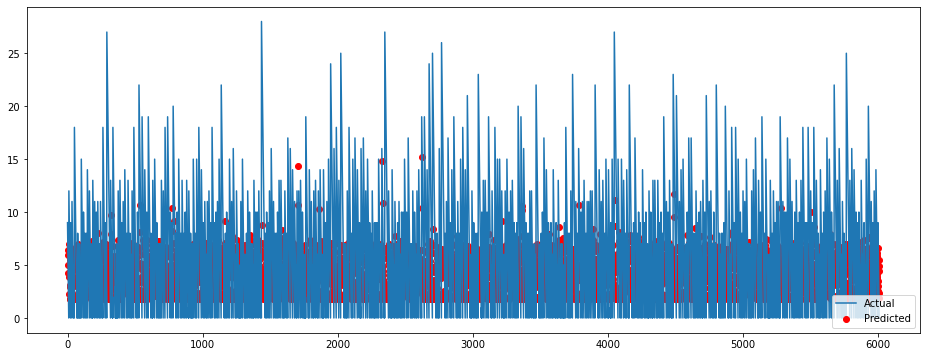

In [33]:
#training set
trainTimeLabels = [i for i in range(6010)]
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels, actualTrain2)
plt.scatter(trainTime_4step_TAD, trainPredict2, color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

C:\Users\NG ZHI QING\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


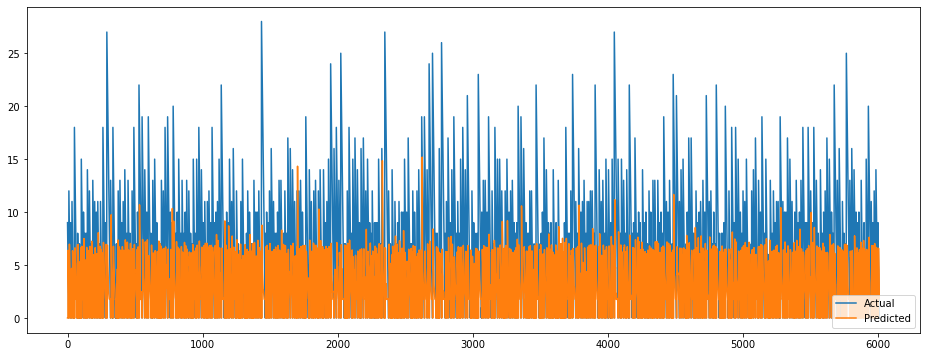

In [34]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels, actualTrain2)
plt.plot(trainTimeLabels, predictedTrain2)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

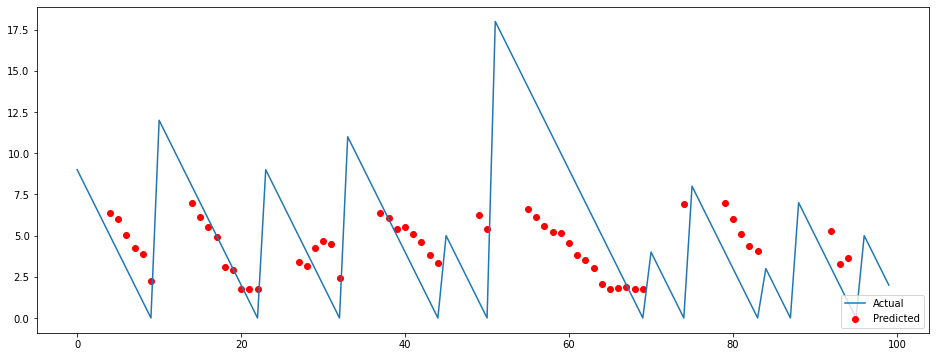

In [35]:
plt.figure(figsize=(16, 6))
plt.plot(trainTimeLabels[0:100], actualTrain2[0:100])
plt.scatter(trainTime_4step_TAD[0:55], trainPredict2[0:55], color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

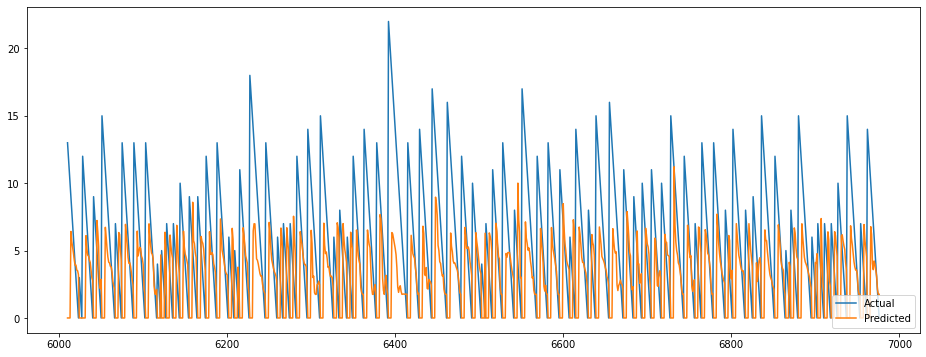

In [36]:
#validation set
valTimeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels, actualVal2)
plt.plot(valTimeLabels, predictedVal2)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

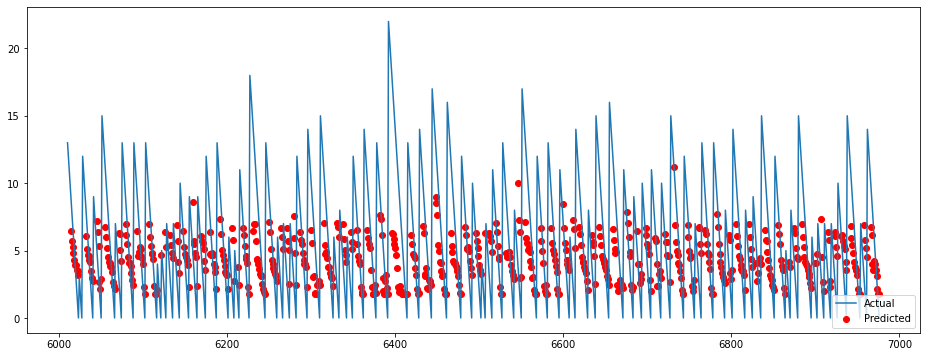

In [37]:
#validation set
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels, actualVal2)
plt.scatter(valTime_4step_TAD, valPredict2, color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

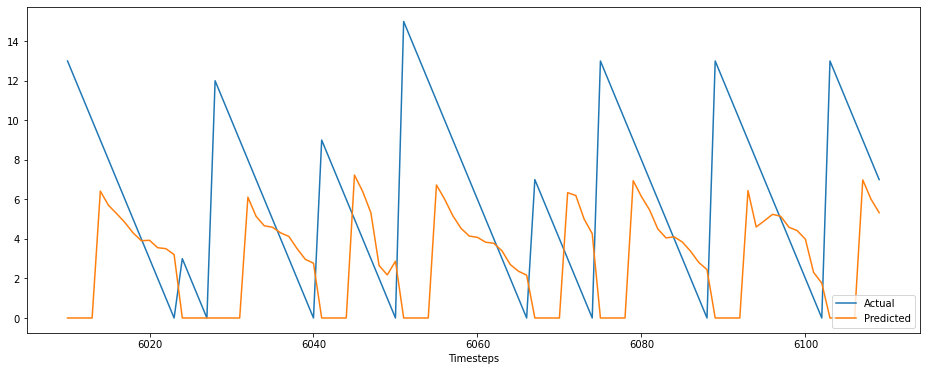

In [38]:
#validation set
valTimeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels[:100], actualVal2[:100])
plt.plot(valTimeLabels[:100], predictedVal2[:100])
plt.xlabel('Timesteps')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

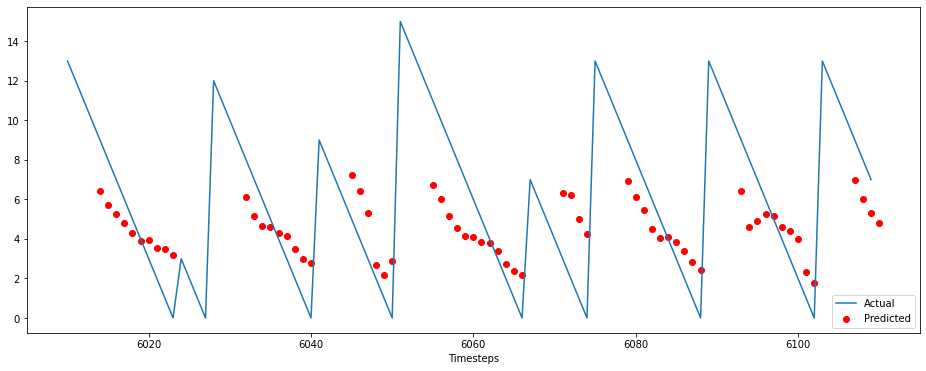

In [39]:
plt.figure(figsize=(16, 6))
plt.plot(valTimeLabels[0:100], actualVal2[0:100])
plt.scatter(valTime_4step_TAD[0:65], valPredict2[0:65], color='r')
plt.xlabel('Timesteps')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

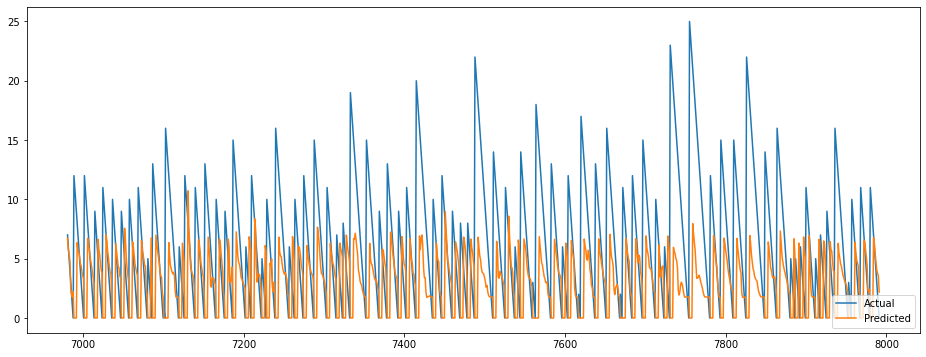

In [40]:
#test set
testTimeLabels = [i for i in range(6981, 7992)]
plt.figure(figsize=(16, 6))
plt.plot(testTimeLabels, actualTest2)
plt.plot(testTimeLabels, predictedTest2)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

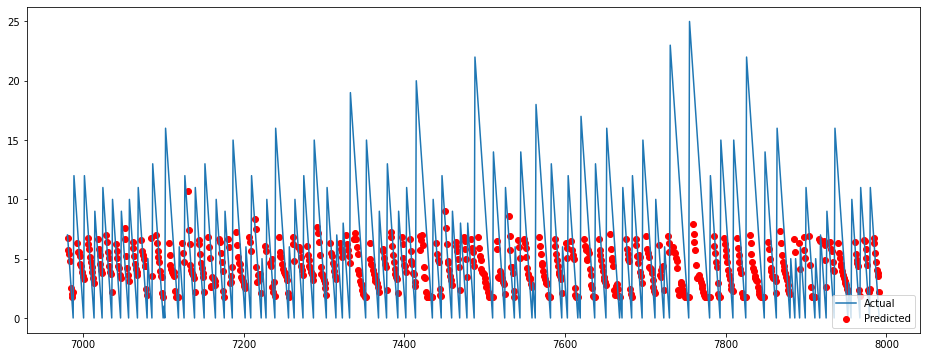

In [41]:
#test set
plt.figure(figsize=(16, 6))
plt.plot(testTimeLabels, actualTest2)
plt.scatter(testTime_4step_TAD, testPredict2, color='r')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

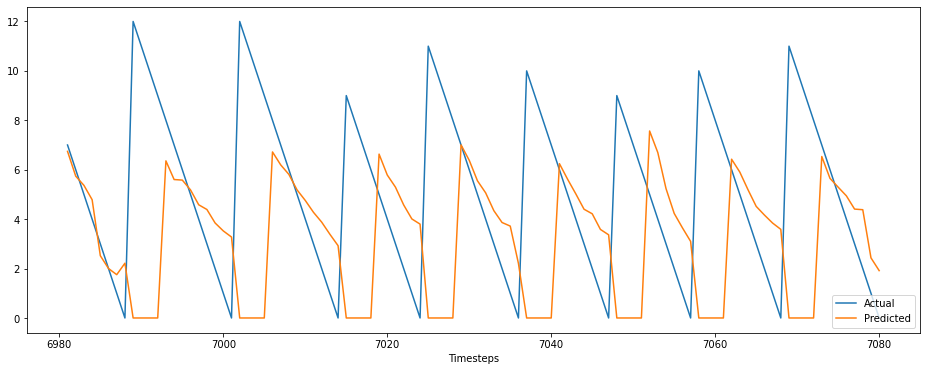

In [42]:
#test set
plt.figure(figsize=(16, 6))
plt.plot(testTimeLabels[:100], actualTest2[:100])
plt.plot(testTimeLabels[:100], predictedTest2[:100])
plt.xlabel('Timesteps')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

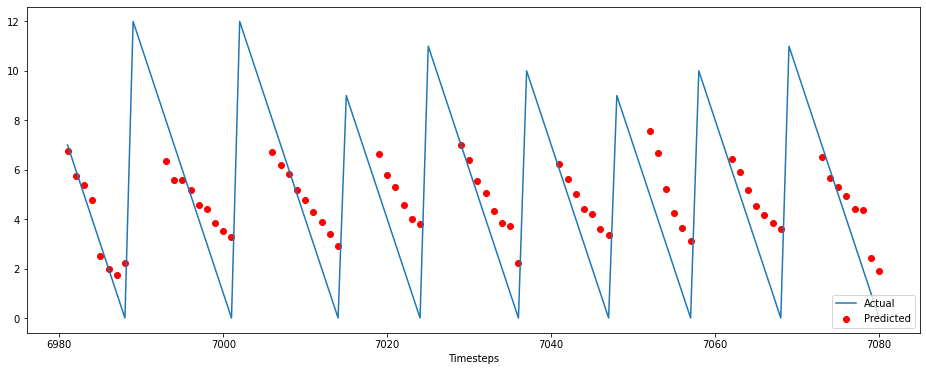

In [43]:
plt.figure(figsize=(16, 6))
plt.plot(testTimeLabels[0:100], actualTest2[0:100])
plt.scatter(testTime_4step_TAD[0:68], testPredict2[0:68], color='r')
plt.xlabel('Timesteps')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()